In [89]:
from tqdm import tqdm 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
import scipy
from scipy.sparse import csgraph
from numpy import linalg as LA
import scipy.cluster.hierarchy as sch
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering, AffinityPropagation
warnings.filterwarnings('ignore')

## Load data 

* Total drugs in the dataset = 485 
* Total features = 68
* Total biological properties (textual features/network information) = 4
    1. Drug-MOA = 371 x 177
    2. Drug-Pathway = 323 x 134
    3. Drug-Target = 328 x 626
    4. Drug-Indication = 435 x 180
* Total numerical features (chemical/physical properties/pharmacokinetics) = 4


In [91]:
#this just contains each drug compared with each possible MOA
#look at the csv file once youll get it
drug_moa_df = pd.read_csv('DATA-PREPROCESSING/df_moa_relationship.csv')
drug_indication_df = pd.read_csv('DATA-PREPROCESSING/df_indication_relationship.csv')
drug_pathway_df = pd.read_csv('DATA-PREPROCESSING/df_pathway_relationship.csv')
drug_target_df = pd.read_csv('DATA-PREPROCESSING/df_target_relationship.csv')
#list of drugs(only) under Clinical trial
drug_df = pd.read_csv('drug_nodes_CT.csv')
#this file consists of all the processed combined data(again a file with 0s and 1s) from preprocessing
drug_num_df = pd.read_csv('DATA-PREPROCESSING/all_drug_data_processed.csv')
#consists of names of all drugs under clinical trial
drug_full = drug_df['Name'].tolist()

## Comparing Different Clustering Frameworks for Tier-1 

* All clusters will be evaluated using silhouette_score as true labels are not available. 
* adjusted_rand_score is used to compare the level of similarity of best clusters from all 4 frameworks. 
* Frameworks compared are as follows:
    1. KMeans Clustering 
    2. Spectral Clustering
    3. Hierarchial Clustering


### Framework for KMeans

In [98]:
#this function encodes the names of the drugs and normalizes the data

def load_data(df_org):
  df = df_org.copy()
  #this LabelEncoder converts all the drug names to numbers
  le = LabelEncoder()
  y = df['Name']
  #fit_transform is to ensure each drug gets a unique number
  df['Name'] = le.fit_transform(df['Name'])
  y = le.transform(y)
  cols = df.columns
  #normalizing all values in range of [0,1]
  ms = MinMaxScaler()
  X = ms.fit_transform(df)
  X = pd.DataFrame(X, columns=[cols])
  return df,y,X

%matplotlib inline  
#K-means
def k_means_elbow_method(X,title):
  #cs contains all the inertia values for different parameters of the KMeans model
  cs = []
  #300 is the max number of clusters 
  #this code experiments 
  for i in tqdm(range(1,300),desc="k-means clustering"):
      #n_clusters:number of clusters
      #init:method used here optimizes initial centroids
      #max_iter:maximum number of iterations before it stops for one n_cluster value
      #n_init:runs the algo with different initial centroids 10 times
      #random_state=0 just means we will get different results everytime
      kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
      #fitting the model to the dataset
      kmeans.fit(X)
      #inertia is the error estimation method
      #finds the square of the distance between each data point and its cluster centroid
      #lower the value the better
      #if value is too low, overfitting
      cs.append(kmeans.inertia_)
    
  plt.plot(range(1,300), cs)
  plt.title('The Elbow Method '+title)
  plt.xlabel('Number of clusters')
  plt.ylabel('CS')
  plt.show()

def k_means_clustering(nclusters,X):
  kmeans = KMeans(n_clusters=nclusters, random_state=0) 
  kmeans.fit(X)
  kmeans.cluster_centers_
  #print(f"Kmeans inertia: {kmeans.inertia_}")
  return kmeans.labels_

#this is to create a dataframe consisting of the drug names, cluster_label and node_label(i.e the encoded values)
#this dataframe is converted to a csv file
def make_df(labels,y,name,df_org):
  df = pd.DataFrame({'node-value':y, 'cluster-label':labels})
  df['drug'] = df_org['Name']
  df = df.sort_values('cluster-label')
  #fileName = 'data/T1/' + name
  fileName = name
  df.to_csv(fileName)
  return df
#ensures that the new kmeans file has all the drugs
#if not, it adds the missing drugs
def complete_df(df,drug_full,name,folder_name):
  df = df.drop('node-value', axis=1)
  drug_subset = df['drug'].tolist()
  missing_drug = list(set(drug_full)-set(drug_subset))
  xtra = {'drug': missing_drug}
  xtra_df = pd.DataFrame(xtra)
  df = pd.concat([df,xtra_df],ignore_index=True)
  #fileName = 'data/T1-Inter-CT/' + name
  fileName = f"{folder_name}_Tier1/{name}"
  df.to_csv(fileName)
  #return df

### K-Means implementation for MOA

k-means clustering: 100%|██████████| 299/299 [01:04<00:00,  4.61it/s]


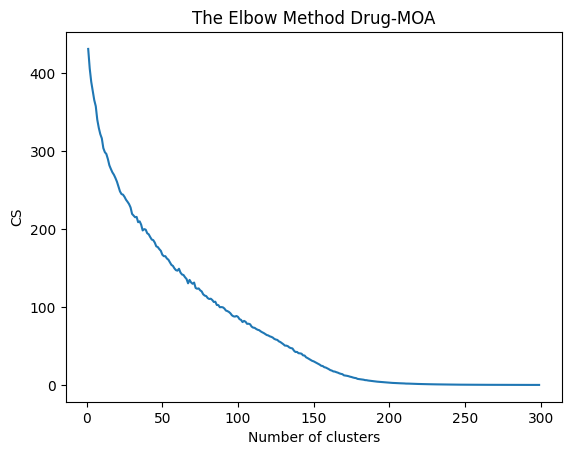

In [93]:
df_drug_moa,y_drug_moa,X_drug_moa = load_data(drug_moa_df)
k_means_elbow_method(X_drug_moa,'Drug-MOA')
# 80 seems appropriate

In [99]:
label_drug_moa = k_means_clustering(160,X_drug_moa)
df_new_drug_moa = make_df(label_drug_moa,y_drug_moa,'Drug-MOA-Kmeans.csv',drug_moa_df)
print('silhouette_score')
silhoutte_score_moa_kmeans = metrics.silhouette_score(X_drug_moa, label_drug_moa, metric='euclidean')
complete_df(df_new_drug_moa,drug_full,'Drug-MOA-KMeans.csv',"MOA")

print(silhoutte_score_moa_kmeans)


silhouette_score
0.5433209302385045


### K-Means implementation for Drug Pathway

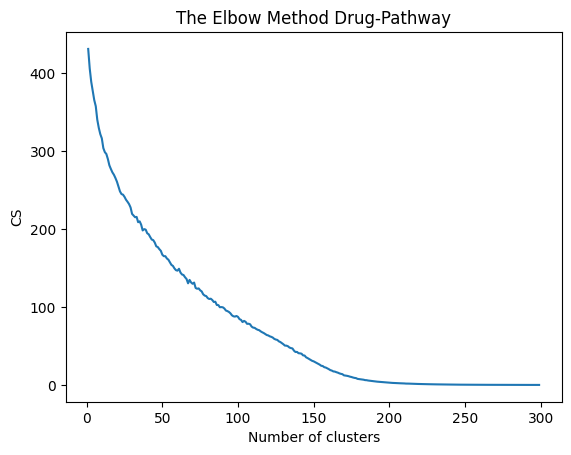

In [32]:
df_drug_path,y_drug_path,X_drug_path = load_data(drug_pathway_df)
k_means_elbow_method(X_drug_moa,'Drug-Pathway')
# 80 seems appropriate

In [100]:
label_drug_path = k_means_clustering(160,X_drug_path)
df_new_drug_path = make_df(label_drug_path,y_drug_path,'Drug-Pathway-Kmeans.csv',drug_pathway_df)
print('silhouette_score')
silhoutte_score_path_kmeans = metrics.silhouette_score(X_drug_path, label_drug_path, metric='euclidean')
complete_df(df_new_drug_path,drug_full,'Drug-Pathway-KMeans.csv',"Pathway")

silhouette_score


### K-Means implementation for Drug Target

k-means clustering: 100%|██████████| 299/299 [04:38<00:00,  1.07it/s]


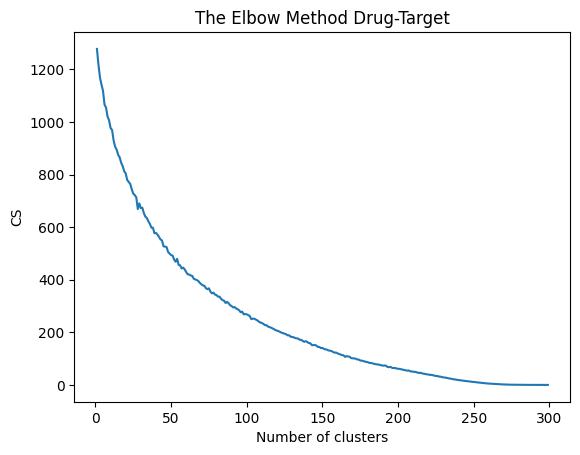

In [38]:
df_drug_target,y_drug_target,X_drug_target = load_data(drug_target_df)
k_means_elbow_method(X_drug_target,'Drug-Target')
# 80 seems appropriate

In [101]:
label_drug_target = k_means_clustering(170,X_drug_target)
df_new_drug_target = make_df(label_drug_target,y_drug_target,'Drug-Target-Kmeans.csv',drug_target_df)
print('silhouette_score')
silhouette_score_target_kmeans = metrics.silhouette_score(X_drug_target, label_drug_target, metric='euclidean')
complete_df(df_new_drug_target,drug_full,'Drug-Target-KMeans.csv',"Target")

silhouette_score


### K-Means implementation for Drug Indication

k-means clustering: 100%|██████████| 299/299 [01:14<00:00,  4.00it/s]


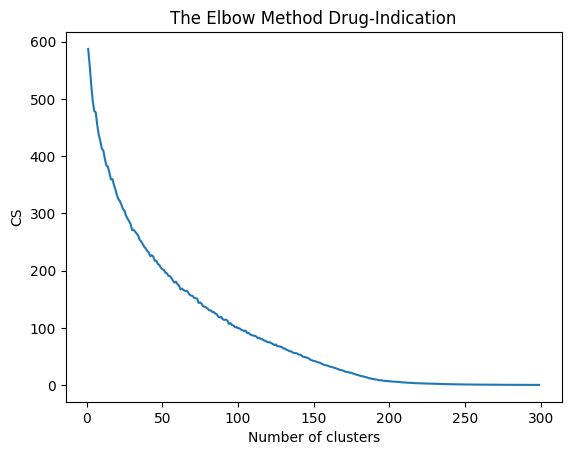

In [40]:
df_drug_indication,y_drug_indication,X_drug_indication = load_data(drug_indication_df)
k_means_elbow_method(X_drug_indication,'Drug-Indication')
# 80 seems appropriate

In [102]:
label_drug_indication = k_means_clustering(200,X_drug_indication)
df_new_drug_indication = make_df(label_drug_indication,y_drug_indication,'Drug-Indication-Kmeans.csv',drug_indication_df)
print('silhouette_score')
silhouette_score_indication_kmeans = metrics.silhouette_score(X_drug_indication, label_drug_indication, metric='euclidean')
complete_df(df_new_drug_indication,drug_full,'Drug-Indication-KMeans.csv',"Indication")

silhouette_score


### Framework for Spectral Clustering

### Affinity Matrix Calculation

In [42]:
def getAffinityMatrix(coordinates, k = 7):
    #the affinity matrix has values that give the similarity values
    #higher values signify stronger similarity between data points
    """
    Calculate affinity matrix based on input coordinates matrix and the number
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    #pdist to calculate pairwise eucledian distance
    #squareform to convert into a symmetric matrix
    dists = squareform(pdist(coordinates)) 
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    #computes square of euclidean distance
    #Normalizes distances
    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    #handling the matrix where null values exist
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix



### Eigen Decomposition Calculation

In [43]:
def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    # affinity matrix is converted to a laplacian matrix
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    #eigen value decomposition on the laplacian matrix 
    eigenvalues, eigenvectors = LA.eig(L)
    #plotting the eigen values and eigen matrices
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    #computes difference between consecutive eigen values 
    #Finds the largest gaps → the position of the largest eigenvalue jump is the optimal number of clusters
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

### Spectral Clustering Implementation for MOA 

In [44]:
df_drug_moa,y_drug_moa,X_drug_moa = load_data(drug_moa_df)
y = drug_moa_df['Name']
X_moa = drug_moa_df.drop('Name',axis=1)

Optimal number of clusters [  1   4  13 112 225]


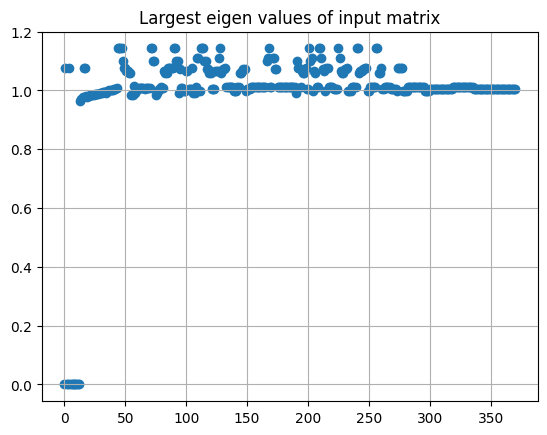

In [45]:
affinity_matrix_moa = getAffinityMatrix(X_moa, k = 7)
k, _,  _ = eigenDecomposition(affinity_matrix_moa)
print(f'Optimal number of clusters {k}')

In [103]:
clustering = SpectralClustering(n_clusters=253, assign_labels="discretize", random_state=0).fit(X_moa)
y_pred = clustering.labels_
print('silhouette_score')
silhouette_score_moa_spectral = metrics.silhouette_score(X_moa,y_pred, metric='euclidean')
df_new_drug_moa = make_df(y_pred,y_drug_moa,'Drug-MOA-SC.csv',drug_moa_df)
complete_df(df_new_drug_moa,drug_full,'Drug-MOA-SC.csv',"MOA")

silhouette_score


### Spectral Clustering Implementation for  Drug Pathway

In [47]:
df_drug_path,y_drug_path,X_drug_path = load_data(drug_pathway_df)
y = drug_pathway_df['Name']
X_path = drug_pathway_df.drop('Name',axis=1)

Optimal number of clusters [ 1 25  9  5 46]


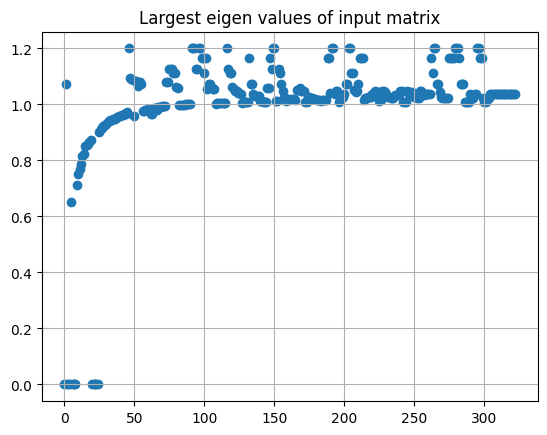

In [49]:
affinity_matrix_path = getAffinityMatrix(X_path, k = 5)
k, _,  _ = eigenDecomposition(affinity_matrix_path)
print(f'Optimal number of clusters {k}')

In [104]:
clustering = SpectralClustering(n_clusters=70, assign_labels="discretize", random_state=0).fit(X_path)
y_pred = clustering.labels_
print('silhouette_score')
silhouette_score_path_spectral = metrics.silhouette_score(X_path,y_pred, metric='euclidean')
df_new_drug_path = make_df(y_pred,y_drug_path,'Drug-Pathway-SC.csv',drug_pathway_df)
complete_df(df_new_drug_path,drug_full,'Drug-Pathway-SC.csv',"Pathway")

silhouette_score


### Spectral Clustering Implementation for Drug Target

In [51]:
df_drug_target,y_drug_target,X_drug_target = load_data(drug_target_df)
y = drug_target_df['Name']
X_target = drug_target_df.drop('Name',axis=1)

Optimal number of clusters [ 2  3 55 12 23]


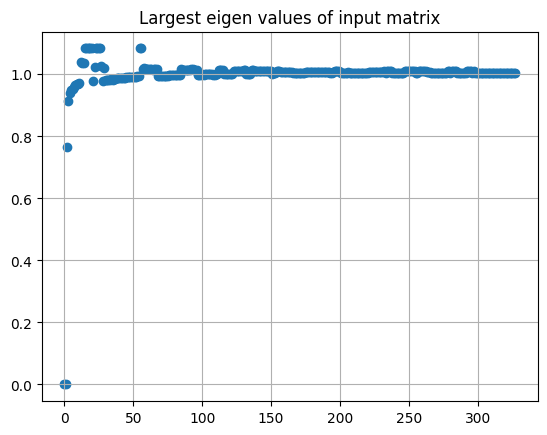

In [52]:
affinity_matrix_target = getAffinityMatrix(X_target, k = 10)
k, _,  _ = eigenDecomposition(affinity_matrix_target)
print(f'Optimal number of clusters {k}')

In [105]:
clustering = SpectralClustering(n_clusters=76, assign_labels="discretize", random_state=0).fit(X_target)
y_pred = clustering.labels_
print('silhouette_score')
silhouette_score_target_spectral = metrics.silhouette_score(X_target,y_pred, metric='euclidean')
df_new_drug_target = make_df(y_pred,y_drug_target,'Drug-Target-SC.csv',drug_target_df)
complete_df(df_new_drug_target,drug_full,'Drug-Target-SC.csv',"Target")

silhouette_score


### Spectral Clustering Implementation for Drug Indication

In [54]:
df_drug_indication,y_drug_indication,X_drug_indication = load_data(drug_indication_df)
y = drug_indication_df['Name']
X_indication = drug_indication_df.drop('Name',axis=1)

Optimal number of clusters [ 11   7 176 187 354]


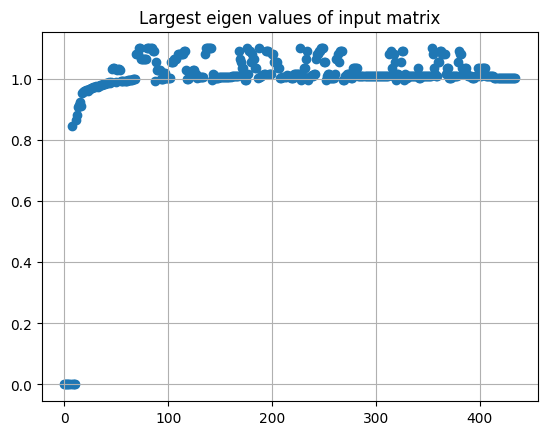

In [55]:
affinity_matrix_indication = getAffinityMatrix(X_indication, k = 7)
k, _,  _ = eigenDecomposition(affinity_matrix_indication)
print(f'Optimal number of clusters {k}')

In [106]:
clustering = SpectralClustering(n_clusters=16, assign_labels="discretize", random_state=0).fit(X_indication)
y_pred = clustering.labels_
print('silhouette_score')
silhouette_score_indication_spectral = metrics.silhouette_score(X_indication,y_pred, metric='euclidean')
df_new_drug_indication = make_df(y_pred,y_drug_indication,'Drug-Indication-SC.csv',drug_indication_df)
complete_df(df_new_drug_indication,drug_full,'Drug-Indication-SC.csv',"Indication")

silhouette_score


### Hierarchial Clustering of MOA

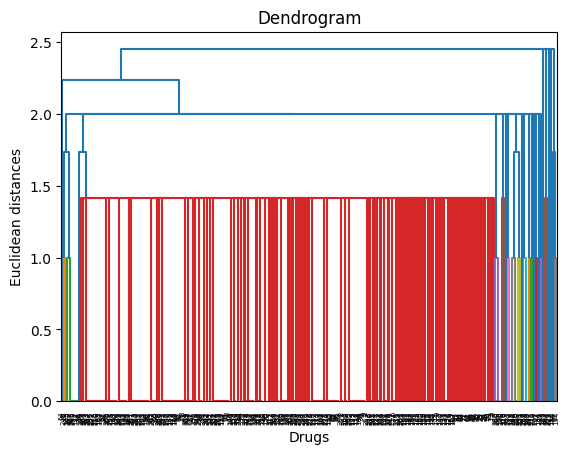

In [57]:
#tree-like diagram helps to find optimal clusters in a hierarchical clustering
#complete linkage method
dendrogram = sch.dendrogram(sch.linkage(X_moa, method = 'complete')) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram') # title of the dendrogram
plt.xlabel('Drugs') # label of the x-axis
plt.ylabel('Euclidean distances') # label of the y-axis
plt.show() # show the dendrogram

In [107]:
#for agglomerative clustering reference:https://www.geeksforgeeks.org/hierarchical-clustering/

clustering_model = AgglomerativeClustering(n_clusters=80,metric='euclidean', linkage='ward')
clustering_model.fit(X_moa)
print('silhouette_score')
silhouette_score_moa_hierarchy = metrics.silhouette_score(X_moa,clustering_model.labels_, metric='euclidean')
df_new_drug_moa = make_df(clustering_model.labels_,y_drug_moa,'Drug-MOA-HC.csv',drug_moa_df)
complete_df(df_new_drug_moa,drug_full,'Drug-MOA-HC.csv',"MOA")

silhouette_score


### Hierarchial Clustering of Drug Pathway

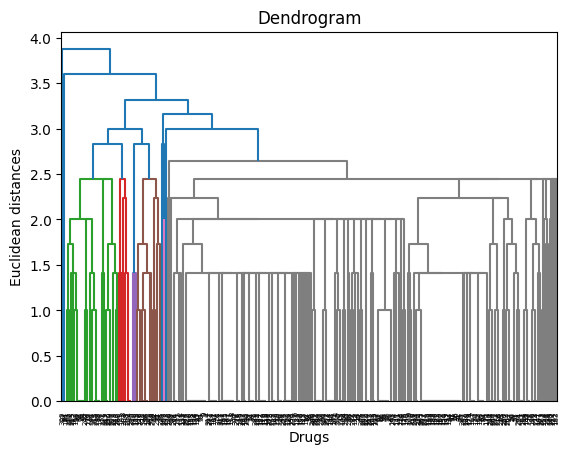

In [60]:
dendrogram = sch.dendrogram(sch.linkage(X_path, method = 'complete')) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram') # title of the dendrogram
plt.xlabel('Drugs') # label of the x-axis
plt.ylabel('Euclidean distances') # label of the y-axis
plt.show() # show the dendrogram

In [108]:
clustering_model = AgglomerativeClustering(n_clusters=140, metric='euclidean', linkage='ward')
clustering_model.fit(X_path)
print('silhouette_score')
silhouette_score_path_hierarchy = metrics.silhouette_score(X_path,clustering_model.labels_, metric='euclidean')
df_new_drug_path = make_df(clustering_model.labels_,y_drug_path,'Drug-Pathway-HC.csv',drug_pathway_df)
complete_df(df_new_drug_path,drug_full,'Drug-Pathway-HC.csv',"Pathway")

silhouette_score


### Hierarchial Clustering of Drug Target

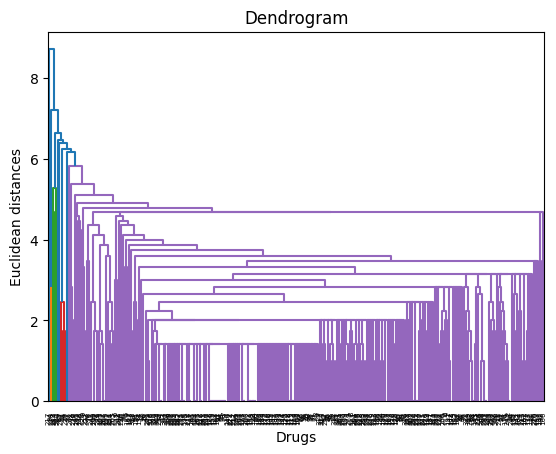

In [62]:
dendrogram = sch.dendrogram(sch.linkage(X_target, method = 'complete')) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram') # title of the dendrogram
plt.xlabel('Drugs') # label of the x-axis
plt.ylabel('Euclidean distances') # label of the y-axis
plt.show() # show the dendrogram

In [109]:
clustering_model = AgglomerativeClustering(n_clusters=160, metric='euclidean', linkage='ward')
clustering_model.fit(X_target)
print('silhouette_score')
silhouette_score_target_hierarchy = metrics.silhouette_score(X_target,clustering_model.labels_, metric='euclidean')
df_new_drug_target = make_df(clustering_model.labels_,y_drug_target,'Drug-Target-HC.csv',drug_target_df)
complete_df(df_new_drug_target,drug_full,'Drug-Target-HC.csv',"Target")

silhouette_score


### Hierarchial Clustering of Drug Indication

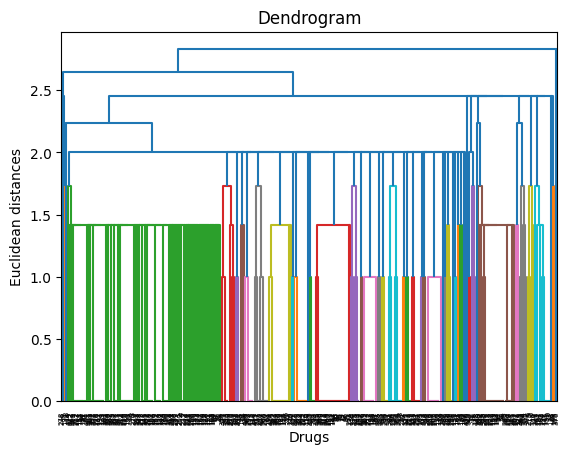

In [64]:
dendrogram = sch.dendrogram(sch.linkage(X_indication, method = 'complete')) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram') # title of the dendrogram
plt.xlabel('Drugs') # label of the x-axis
plt.ylabel('Euclidean distances') # label of the y-axis
plt.show() # show the dendrogram

In [110]:
clustering_model = AgglomerativeClustering(n_clusters=180, metric='euclidean', linkage='ward')
clustering_model.fit(X_indication)
print('silhouette_score')
silhouette_score_indication_hierarchy = metrics.silhouette_score(X_indication,clustering_model.labels_, metric='euclidean')
df_new_drug_indication = make_df(clustering_model.labels_,y_drug_indication,'Drug-Indication-HC.csv',drug_indication_df)
complete_df(df_new_drug_indication,drug_full,'Drug-Indication-HC.csv',"Indication")

silhouette_score


In [86]:
data = {
    "Method": ["K-Means", "Spectral", "Heirarchical"],
    "MOA": [silhoutte_score_moa_kmeans, silhouette_score_moa_spectral, silhouette_score_moa_hierarchy],
    "Pathway": [silhoutte_score_path_kmeans, silhouette_score_path_spectral, silhouette_score_path_hierarchy],
    "Target": [silhouette_score_target_kmeans, silhouette_score_target_spectral, silhouette_score_target_hierarchy],
    "Indication": [silhouette_score_indication_kmeans, silhouette_score_indication_spectral, silhouette_score_indication_hierarchy]
}

In [87]:
df_scores = pd.DataFrame(data)
df_scores.head()

,Method,MOA,Pathway,Target,Indication
0,K-Means,0.543321,0.514842,0.243085,0.518570
1,Spectral,0.435208,0.594536,0.172593,0.332557
2,Heirarchical,0.716456,0.722269,0.341399,0.735632


In [111]:
print("As we can see, hierarchical clustering is giving maximum silhoutte scores.")

As we can see, hierarchical clustering is giving maximum silhoutte scores.
